In [1]:
import fiona
import math

In [2]:
# fname = 'routes/Route from 2021-02-02 08 27_20210202082755.gpx'
# fname = 'routes/Route from 2021-02-03 08 20_20210203082009.gpx'
fname = 'routes/Route from 2021-01-04 08 27_20210104082708.gpx'

## Fiona

Fiona reads and writes geographic data files

https://fiona.readthedocs.io/en/latest/README.html

In [3]:
fiona.listlayers(fname)

['waypoints', 'routes', 'tracks', 'route_points', 'track_points']

We're interested in the tracks...

In [4]:
layer = fiona.open(fname, layer='tracks')
lon_min, lat_min, lon_max, lat_max = layer.bounds

In [5]:
geom = layer[0]  # first track? (my data only has one per file, AFAIK)
print(geom.keys())
print(geom['type'])
print(geom['id'])
print(geom['properties']['name'])
print(geom['geometry'].keys())

dict_keys(['type', 'id', 'properties', 'geometry'])
Feature
0
Route from 2021-01-04 08:27
dict_keys(['type', 'coordinates'])


In [6]:
coords = geom['geometry']['coordinates']

In [7]:
from haversine import distance

d = 0.0

for p1, p2 in zip(coords[0], coords[0][1:]):
    d += distance(p1, p2)
    if d < 100:
        print(p1, p2, d)

print(f'total distance: {d:.1f}m ({d * 5.0 / 8000.0:.3f}m)')

(0.112942, 51.425461) (0.112814, 51.4254) 11.17
(0.112814, 51.4254) (0.112734, 51.425369) 17.701
(0.112734, 51.425369) (0.112652, 51.425348) 23.847
(0.112652, 51.425348) (0.11257, 51.42536) 29.687
(0.11257, 51.42536) (0.112477, 51.425297) 39.208
(0.112477, 51.425297) (0.112509, 51.42525) 44.885999999999996
(0.112509, 51.42525) (0.112565, 51.425167) 54.898999999999994
(0.112565, 51.425167) (0.112565, 51.425076) 65.018
(0.112565, 51.425076) (0.112572, 51.425026) 70.599
(0.112572, 51.425026) (0.112572, 51.424971) 76.715
(0.112572, 51.424971) (0.11255, 51.424923) 82.266
(0.11255, 51.424923) (0.112564, 51.424863) 89.00800000000001
(0.112564, 51.424863) (0.112566, 51.424799) 96.126
total distance: 5817.9m (3.636m)


In [8]:
from shapely.geometry import shape

In [9]:
data = {'type': 'MultiLineString', 'coordinates': coords}

shp = shape(data)

# Cartopy

https://scitools.org.uk/cartopy/docs/latest/index.html

Cartopy is a Python package designed for geospatial data processing in order to produce maps and other geospatial data analyses.

crs: coordinate reference system

PlateCarree: Equirectangular projection [Wikipedia article](https://en.wikipedia.org/wiki/Equirectangular_projection)

Other projections are available, see https://scitools.org.uk/cartopy/docs/latest/crs/projections.html


In [10]:
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

c:\users\mikew\documents\github\mwalks\venv\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\users\mikew\documents\github\mwalks\venv\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


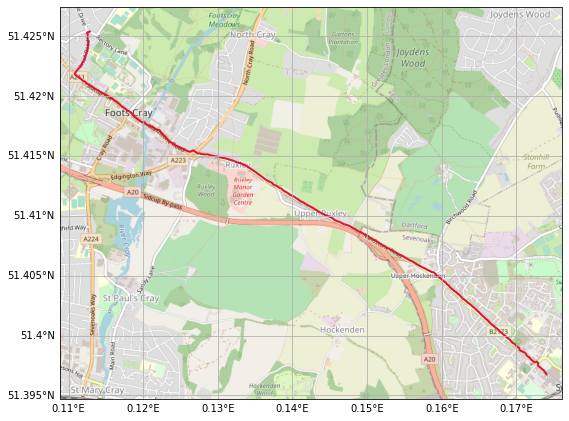

In [11]:
import cartopy.io.img_tiles as cimgt

request = cimgt.OSM()  # Open Street Map

pad_lat = 0.002
pad_lon = 0.002

extent = [lon_min - pad_lon, lon_max + pad_lon, lat_min - pad_lat, lat_max + pad_lat]

fig, ax = make_map(projection=request.crs)
ax.set_extent(extent)

img = ax.add_image(request, 14)
s = ax.add_geometries(shp, ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='crimson',
                      linewidth=2)